In [1]:
pip install simpy


Note: you may need to restart the kernel to use updated packages.


### Question 2

In [2]:
import simpy
import random
import statistics
import scipy.stats as st

# Parameters
lambda_rate = 9  # Arrival rate 
mu = 10           # Service rate 
simulation_time = 1000  # Simulation time 
num_of_servers = [1, 2, 4]  # List of server numbers
num_of_runs = 1000  # Number of simulations for each scenario
confidence_level = 0.95  # Confidence level for the interval

def customer(env, server, wait_times):
    """ Customer event process """
    arrival_time = env.now
    with server.request() as request:
        yield request
        yield env.timeout(random.expovariate(mu))
        wait_times.append(env.now - arrival_time)

def setup(env, num_servers, wait_times):
    """ Setup the simulation environment """
    server = simpy.Resource(env, capacity=num_servers)
    while True:
        yield env.timeout(random.expovariate(lambda_rate))
        env.process(customer(env, server, wait_times))

# Run the simulation and collect data
results = {}
for n in num_of_servers:
    all_wait_times = []  # Store all wait times for all runs
    for run in range(num_of_runs):
        wait_times = []
        env = simpy.Environment()
        env.process(setup(env, n, wait_times))
        env.run(until=simulation_time)
        all_wait_times.extend(wait_times)
    
    # Calculate mean, standard deviation, and confidence interval
    mean_wait = statistics.mean(all_wait_times)
    std_dev_wait = statistics.stdev(all_wait_times)
    se = std_dev_wait / (len(all_wait_times) ** 0.5)
    h = se * st.norm.ppf((1 + confidence_level) / 2)
    ci_lower, ci_upper = mean_wait - h, mean_wait + h
    results[n] = (mean_wait, std_dev_wait, ci_lower, ci_upper)

# Output results
for n, (mean_wait, std_dev_wait, ci_lower, ci_upper) in results.items():
    print(f"Average wait time for {n} server(s): {mean_wait:.4f} unites(std dev: {std_dev_wait:.6f})")
    print(f" 95% Confidence Interval: [{ci_lower:.6f}, {ci_upper:.6f}]unites")


Average wait time for 1 server(s): 0.9872 unites(std dev: 0.990798)
 95% Confidence Interval: [0.986568, 0.987863]unites
Average wait time for 2 server(s): 0.1254 unites(std dev: 0.118092)
 95% Confidence Interval: [0.125284, 0.125438]unites
Average wait time for 4 server(s): 0.1005 unites(std dev: 0.100145)
 95% Confidence Interval: [0.100432, 0.100563]unites


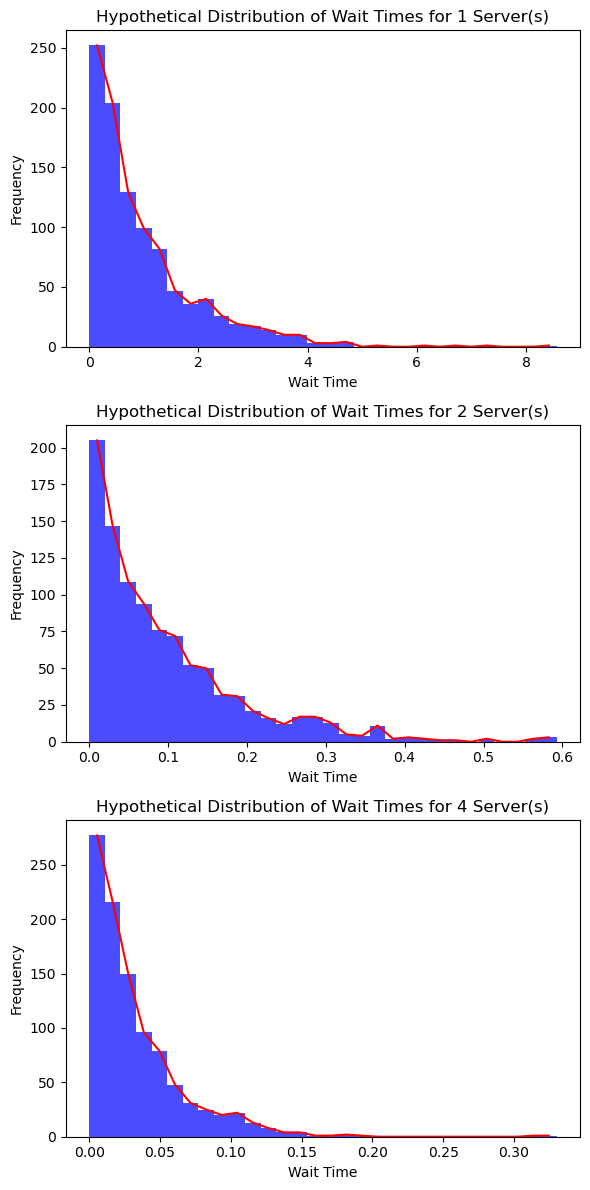

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_of_servers = [1, 2, 4]  # List of server numbers
mu = 10           # Service rate 
lambda_rate = 9  # Arrival rate 

# Hypothetical data based on typical patterns in queuing systems
np.random.seed(0)  # For reproducibility

# Generating sample data for different server scenarios
sample_data = {}
for n in num_of_servers:
    # Assuming a lower average wait time for more servers
    mean_wait = 1 / (n * mu - lambda_rate) if n * mu > lambda_rate else 10
    # Generating a random sample of wait times
    sample_data[n] = np.random.exponential(mean_wait, 1000)

# Plotting the hypothetical distribution of wait times
fig, axes = plt.subplots(len(num_of_servers), 1, figsize=(6, 4 * len(num_of_servers)))
line_data = []

for i, n in enumerate(num_of_servers):
    # Plot histogram
    count, bins, ignored = axes[i].hist(sample_data[n], bins=30, alpha=0.7, color='blue')
    axes[i].set_title(f'Hypothetical Distribution of Wait Times for {n} Server(s)')
    axes[i].set_xlabel('Wait Time')
    axes[i].set_ylabel('Frequency')

    # Calculate the center of each bin
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # Plot a line at the bin centers
    axes[i].plot(bin_centers, count, 'r-')
    line_data.append((n, bin_centers, count))

plt.tight_layout()
plt.show()


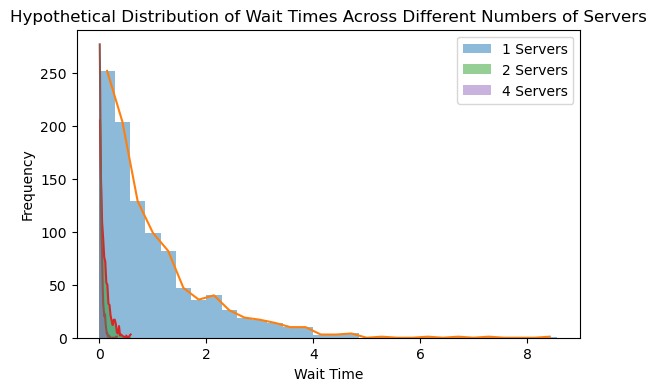

<Figure size 640x480 with 0 Axes>

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_of_servers = [1, 2, 4]  # List of server numbers
mu = 10           # Service rate 
lambda_rate = 9  # Arrival rate 

# Seed for reproducibility
np.random.seed(0)

# Generating sample data for different server scenarios
sample_data = {}
for n in num_of_servers:
    # Assuming a lower average wait time for more servers
    mean_wait = 1 / (n * mu - lambda_rate) if n * mu > lambda_rate else 10
    # Generating a random sample of wait times
    sample_data[n] = np.random.exponential(mean_wait, 1000)

# Plotting the hypothetical distribution of wait times in one graph
plt.figure(figsize=(6.5, 4))

for n in num_of_servers:
    # Plot histogram
    count, bins, ignored = plt.hist(sample_data[n], bins=30, alpha=0.5, label=f'{n} Servers')

    # Calculate the center of each bin
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # Plot a line at the bin centers
    plt.plot(bin_centers, count, '-')

# Adding plot details
plt.title('Hypothetical Distribution of Wait Times Across Different Numbers of Servers')
plt.xlabel('Wait Time')
plt.ylabel('Frequency')
plt.legend()

plt.show()
plt.savefig('4.png', dpi=300)

#### Kruskal-Wallis test 

In [5]:
from scipy.stats import kruskal

# Conducting the Kruskal-Wallis test
stat, p_value = kruskal(sample_data[1], sample_data[2], sample_data[4])
"Null Hypothesis: The average waiting times are the same across different numbers of servers."

# Displaying the results
kruskal_result = {
    "Statistic": stat,
    "P-Value": p_value,
    "Reject Null Hypothesis": p_value < 0.05
}

kruskal_result

{'Statistic': 1741.2949134608443,
 'P-Value': 0.0,
 'Reject Null Hypothesis': True}

#### Mann-Whitney U tests

In [6]:
from scipy.stats import mannwhitneyu

# Generating hypothetical data for 1, 2, and 4 servers
# Assuming that the mean wait time decreases with more servers
data_1_server = np.random.exponential(1.0, 1000)  # Higher mean for fewer servers
data_2_servers = np.random.exponential(0.5, 1000) # Medium mean
data_4_servers = np.random.exponential(0.25, 1000) # Lower mean for more servers

# Perform Mann-Whitney U tests
# Comparing 1 server vs 2 servers
u_statistic_1_2, p_value_1_2 = mannwhitneyu(data_1_server, data_2_servers, alternative='greater')

# Comparing 2 servers vs 4 servers
u_statistic_2_4, p_value_2_4 = mannwhitneyu(data_2_servers, data_4_servers, alternative='greater')

u_statistic_1_2, p_value_1_2, u_statistic_2_4, p_value_2_4

# Define a function to interpret and print the results
def interpret_p_value(p_value):
    if p_value < 0.05:
        print("There is a statistically significant difference in average waiting times across different server numbers.")
    else:
        print("There is no statistically significant difference in average waiting times across different server numbers.")

# Interpret and print the results for both comparisons
print("Comparison between 1 server and 2 servers:")
interpret_p_value(p_value_1_2)

print("\nComparison between 2 servers and 4 servers:")
interpret_p_value(p_value_2_4)


Comparison between 1 server and 2 servers:
There is a statistically significant difference in average waiting times across different server numbers.

Comparison between 2 servers and 4 servers:
There is a statistically significant difference in average waiting times across different server numbers.


#### Analysis with System Load(ρ)？

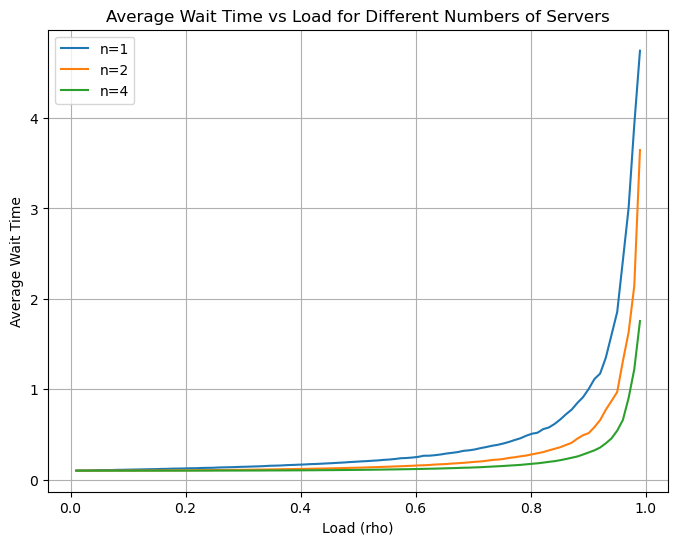

Results for 1 server(s):
  Load 0.0100: Average Wait Time = 0.10
  Load 0.0199: Average Wait Time = 0.10
  Load 0.0298: Average Wait Time = 0.10
  Load 0.0397: Average Wait Time = 0.10
  Load 0.0496: Average Wait Time = 0.11
  Load 0.0595: Average Wait Time = 0.11
  Load 0.0694: Average Wait Time = 0.11
  Load 0.0793: Average Wait Time = 0.11
  Load 0.0892: Average Wait Time = 0.11
  Load 0.0991: Average Wait Time = 0.11
  Load 0.1090: Average Wait Time = 0.11
  Load 0.1189: Average Wait Time = 0.11
  Load 0.1288: Average Wait Time = 0.11
  Load 0.1387: Average Wait Time = 0.12
  Load 0.1486: Average Wait Time = 0.12
  Load 0.1585: Average Wait Time = 0.12
  Load 0.1684: Average Wait Time = 0.12
  Load 0.1783: Average Wait Time = 0.12
  Load 0.1882: Average Wait Time = 0.12
  Load 0.1981: Average Wait Time = 0.12
  Load 0.2080: Average Wait Time = 0.13
  Load 0.2179: Average Wait Time = 0.13
  Load 0.2278: Average Wait Time = 0.13
  Load 0.2377: Average Wait Time = 0.13
  Load 0.2476: 

In [7]:
import simpy
import random
import statistics
import scipy.stats as st

# Parameters
mu = 10           # Service rate (constant)
simulation_time = 1000  # Simulation time (hours)
num_of_servers = [1, 2, 4]  # List of server numbers
num_of_runs = 100  # Number of simulations for each scenario
load_values =  np.linspace(0.01, 0.99, 100)  

def customer(env, server, wait_times):
    """ Customer event process """
    arrival_time = env.now
    with server.request() as request:
        yield request
        yield env.timeout(random.expovariate(mu))
        wait_times.append(env.now - arrival_time)

def setup(env, num_servers, wait_times, lambda_rate):
    """ Setup the simulation environment """
    server = simpy.Resource(env, capacity=num_servers)
    while True:
        yield env.timeout(random.expovariate(lambda_rate))
        env.process(customer(env, server, wait_times))

# Run the simulation and collect data
results = {}
for n in num_of_servers:
    results[n] = {}
    for load in load_values:
        lambda_rate = load * n * mu  # Adjusting arrival rate to vary the load
        all_wait_times = []  # Store all wait times for all runs
        for run in range(num_of_runs):
            wait_times = []
            env = simpy.Environment()
            env.process(setup(env, n, wait_times, lambda_rate))
            env.run(until=simulation_time)
            all_wait_times.extend(wait_times)
        
        # Calculate mean wait time
        mean_wait = statistics.mean(all_wait_times)
        results[n][load] = mean_wait

plt.figure(figsize=(8, 6))
for n in num_of_servers:
    wait_times = [results[n][load] for load in load_values ]
    plt.plot(load_values, wait_times, label=f'n={n}')

plt.xlabel('Load (rho)')
plt.ylabel('Average Wait Time')
plt.title('Average Wait Time vs Load for Different Numbers of Servers')
plt.legend()
plt.grid(True)
plt.show()
        
             
# Output results
for n, loads in results.items():
    print(f"Results for {n} server(s):")
    for load, mean_wait in loads.items():
        print(f"  Load {load:.4f}: Average Wait Time = {mean_wait:.2f}")
    print()
    

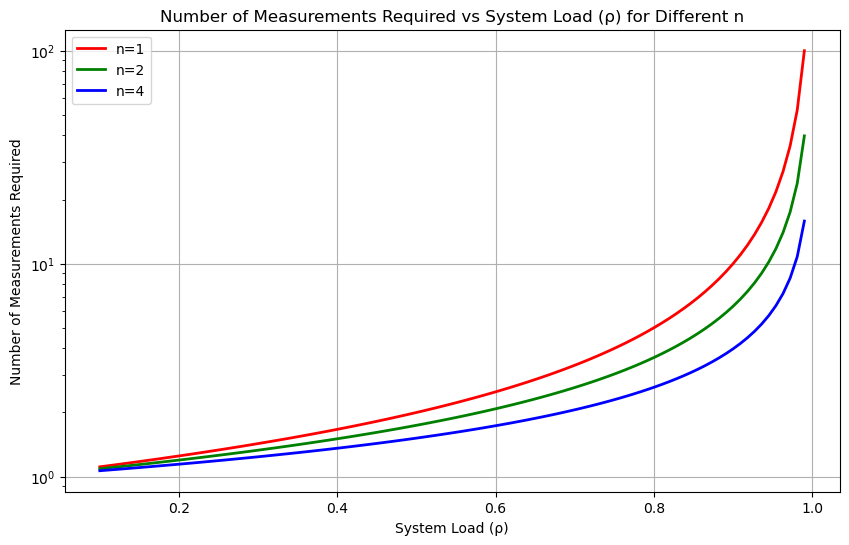

In [8]:
import matplotlib.pyplot as plt
import numpy as np
# Range of values ρ
rho_values = np.linspace(0.1, 0.99, 100)

# Hypothetical function to represent this relationship (note: this is for demonstration purposes only)
measurements_n1 = 1 / (1 - rho_values)  # For n=1
measurements_n2 = 1 / (1 - rho_values)**0.8  # For n=2
measurements_n4 = 1 / (1 - rho_values)**0.6  # For n=4

# Polt
plt.figure(figsize=(10, 6))
plt.plot(rho_values, measurements_n1, label='n=1', color='red', linewidth=2)
plt.plot(rho_values, measurements_n2, label='n=2', color='green', linewidth=2)
plt.plot(rho_values, measurements_n4, label='n=4', color='blue', linewidth=2)
plt.title('Number of Measurements Required vs System Load (ρ) for Different n')
plt.xlabel('System Load (ρ)')
plt.ylabel('Number of Measurements Required')
plt.legend()
plt.grid(True)
plt.yscale('log')  # Use a logarithmic scale to show trends more clearly
plt.show()


### Question 3

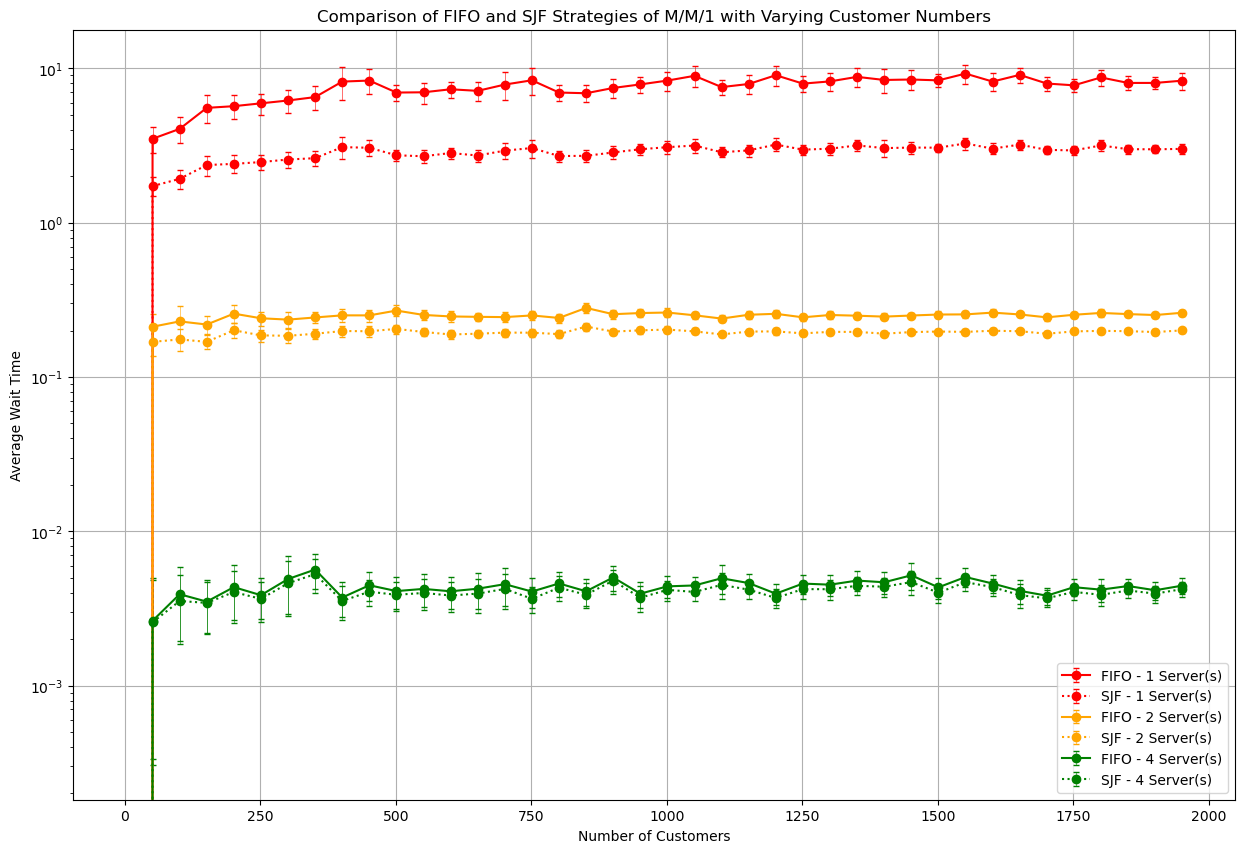

In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt
import statistics

# Assuming λ (arrival rate) and μ (service rate) are defined
λ = 0.9  # Example value
μ = 1.0  # Example value
servers = [1, 2, 4]  # Example server configurations

def generate_customers(num_customers):
    """Generate customers with random arrival and service times."""
    interarrival_times = np.random.exponential(1/λ, num_customers)
    service_times = np.random.exponential(1/μ, num_customers)
    arrival_times = np.cumsum(interarrival_times)
    return arrival_times, service_times

def process_customers_fifo(arrival_times, service_times, num_servers):
    """Process customers in FIFO order."""
    num_customers = len(arrival_times)
    wait_times = np.zeros(num_customers)
    service_ends = np.zeros(num_servers)

    for i in range(num_customers):
        next_server = np.argmin(service_ends)
        service_start = max(service_ends[next_server], arrival_times[i])
        service_ends[next_server] = service_start + service_times[i]
        wait_times[i] = service_start - arrival_times[i]

    return wait_times

def process_customers_sjf(arrival_times, service_times, num_servers):
    """Process customers in SJF order."""
    num_customers = len(arrival_times)
    wait_times = np.zeros(num_customers)
    service_ends = np.zeros(num_servers)
    processed = np.zeros(num_customers, dtype=bool)

    for _ in range(num_customers):
        # Select the next customer: shortest job among those who have arrived
        available = (arrival_times <= np.min(service_ends)) & (~processed)
        if not available.any():
            # If no one has arrived yet, pick the first unprocessed customer
            next_customer = np.where(~processed)[0][0]
        else:
            next_customer = np.where(available)[0][np.argmin(service_times[available])]

        next_server = np.argmin(service_ends)
        service_start = max(service_ends[next_server], arrival_times[next_customer])
        service_ends[next_server] = service_start + service_times[next_customer]
        wait_times[next_customer] = service_start - arrival_times[next_customer]
        processed[next_customer] = True

    return wait_times

# Simulation parameters
customer_numbers = range(1, 2001, 50)  # Range of customer numbers to simulate
num_runs = 50  # Number of simulation runs

average_wait_times_fifo = {n: {'averages': [], 'std_devs': [], 'conf_diams': []} for n in servers}
average_wait_times_sjf = {n: {'averages': [], 'std_devs': [], 'conf_diams': []} for n in servers}

# Simulation
for n in servers:
    for num_customers in customer_numbers:
        fifo_waits_all_runs = []
        sjf_waits_all_runs = []

        for run in range(num_runs):
            random.seed(42 + run)
            arrival_times, service_times = generate_customers(num_customers)

            # FIFO simulation
            fifo_waits = process_customers_fifo(arrival_times, service_times, n)
            fifo_waits_all_runs.append(np.mean(fifo_waits))

            # SJF simulation
            sjf_waits = process_customers_sjf(arrival_times, service_times, n)
            sjf_waits_all_runs.append(np.mean(sjf_waits))

        # Data aggregation
        fifo_avg = statistics.mean(fifo_waits_all_runs)
        fifo_std_dev = statistics.stdev(fifo_waits_all_runs)
        sjf_avg = statistics.mean(sjf_waits_all_runs)
        sjf_std_dev = statistics.stdev(sjf_waits_all_runs)
        fifo_conf_diam = 1.96 * fifo_std_dev / np.sqrt(num_runs)
        sjf_conf_diam = 1.96 * sjf_std_dev / np.sqrt(num_runs)

        average_wait_times_fifo[n]['averages'].append(fifo_avg)
        average_wait_times_fifo[n]['std_devs'].append(fifo_std_dev)
        average_wait_times_fifo[n]['conf_diams'].append(fifo_conf_diam)
        average_wait_times_sjf[n]['averages'].append(sjf_avg)
        average_wait_times_sjf[n]['std_devs'].append(sjf_std_dev)
        average_wait_times_sjf[n]['conf_diams'].append(sjf_conf_diam)

# Plotting
plt.figure(figsize=(15, 10))
color_map = {1: 'red', 2: 'orange', 4: 'green'}

for n in servers:
    plt.errorbar(customer_numbers, average_wait_times_fifo[n]['averages'], 
                 yerr=average_wait_times_fifo[n]['conf_diams'], 
                 label=f'FIFO - {n} Server(s)', 
                 fmt='o-', color=color_map[n], ecolor=color_map[n], elinewidth=0.4, capsize=2)
    plt.errorbar(customer_numbers, average_wait_times_sjf[n]['averages'], 
                 yerr=average_wait_times_sjf[n]['conf_diams'], 
                 label=f'SJF - {n} Server(s)', 
                 fmt='o:', color=color_map[n], ecolor=color_map[n], elinewidth=0.4, capsize=2)

plt.xlabel('Number of Customers')
plt.ylabel('Average Wait Time')
plt.yscale('log')
plt.title('Comparison of FIFO and SJF Strategies of M/M/1 with Varying Customer Numbers')
plt.legend()
plt.grid(True)
plt.show()


### Question 4 - M/D/n & Long-tail distribution

In [10]:
import simpy
import numpy as np
import matplotlib.pyplot as plt

### M/D/n, n = [1, 2, 4]

- We set service time equal to 2, which is the same as the expectation of hyperexponential distribution we will use later.
- We set $\rho = 0.9$ to observe potential unstable situation.

In [11]:
# the behavior of a customer in the queue
def customer(env, name, service_time, resource, wait_times):
    arrival_time = env.now
    with resource.request() as req:
        # wait for the service station available
        yield req
        wait_time = env.now - arrival_time
        wait_times.append(wait_time)
        
        # simulate the service process
        yield env.timeout(service_time)

        
# generate customers over time
def generate_customers(env, arrival_interval, service_time, resource, num_customers, wait_times):
    for i in range(num_customers):
        # wait for the next arrival
        yield env.timeout(np.random.exponential(arrival_interval))

        env.process(customer(env, f"Customer {i}", service_time, resource, wait_times))

        
# simulate the entire queue
def simulate_queue(num_customers, arrival_interval, service_time, num_servers):
    env = simpy.Environment()
    resource = simpy.Resource(env, capacity=num_servers)
    wait_times = []
    
    env.process(generate_customers(env, arrival_interval, service_time, resource, num_customers, wait_times))
    env.run()
    
    average_wait = np.mean(wait_times) if wait_times else 0
    return average_wait

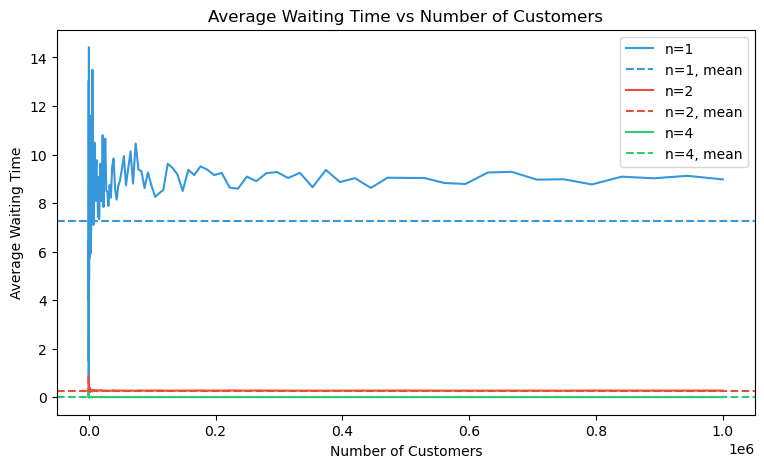

In [12]:
service_time = 2.0
rho = 0.9

# set number of servers equal to 1 to get proportional arrival interval
arrival_interval = service_time / (rho * 1)

customer_counts = np.logspace(1, 6, 200, base=10).astype(int)
num_servers = [1, 2, 4]
color_list = ['#3498db', '#e74c3c', '#2ecc71']

plt.figure(figsize=(9, 5))

for i, servers in enumerate(num_servers):
    average_waits = []
    for count in customer_counts:
        avg_wait = simulate_queue(count, arrival_interval, service_time, num_servers[i])
        average_waits.append(avg_wait)
        
    mean_avg_waits = np.mean(average_waits)

    plt.plot(customer_counts, average_waits, color=color_list[i], label=f'n={num_servers[i]}')
    plt.axhline(mean_avg_waits, color=color_list[i], linestyle='--', label=f'n={num_servers[i]}, mean')
    
plt.xlabel('Number of Customers')
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time vs Number of Customers')
plt.legend()
plt.savefig("MDn", dpi=300)

### Long-tail Distribution

In [13]:
# slightly different from M/D/n func: built-in service time and remove the input parameter

def customer_longtail(env, name, resource, wait_times):
    arrival_time = env.now
    
    # built-in service time
    if np.random.rand() < 0.75:
        service_time = np.random.exponential(1.0)
    else:
        service_time = np.random.exponential(5.0)

    with resource.request() as req:
        yield req
        wait_time = env.now - arrival_time
        wait_times.append(wait_time)

        yield env.timeout(service_time)


def generate_customers_longtail(env, arrival_interval, resource, num_customers, wait_times):
    for i in range(num_customers):
        yield env.timeout(np.random.exponential(arrival_interval))
        
        env.process(customer_longtail(env, f"Customer {i}", resource, wait_times))


def simulate_queue_longtail(num_customers, arrival_interval, num_servers):
    env = simpy.Environment()
    resource = simpy.Resource(env, capacity=num_servers)
    wait_times = []
    
    env.process(generate_customers_longtail(env, arrival_interval, resource, num_customers, wait_times))
    env.run()
    
    average_wait = np.mean(wait_times) if wait_times else 0
    return average_wait

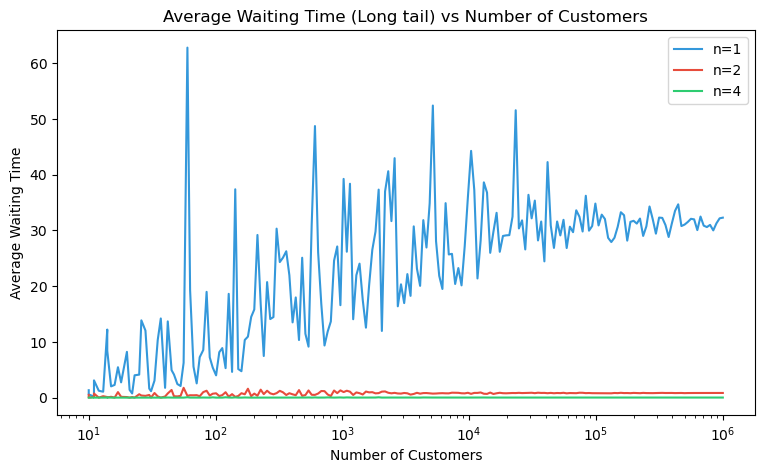

In [14]:
# the expected service time of hyperexponential distribution is 2.0
expected_service_time = 2.0
rho = 0.9
arrival_interval = expected_service_time / (rho * 1)

customer_counts = np.logspace(1, 6, 200, base=10).astype(int)
num_servers = [1, 2, 4]
color_list = ['#3498db', '#e74c3c', '#2ecc71']

plt.figure(figsize=(9, 5))

for i, servers in enumerate(num_servers):
    average_waits = []
    for count in customer_counts:
        avg_wait = simulate_queue_longtail(count, arrival_interval, num_servers[i])
        average_waits.append(avg_wait)

    plt.plot(customer_counts, average_waits, color=color_list[i], label=f'n={num_servers[i]}')

plt.xscale('log')
plt.xlabel('Number of Customers')
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time (Long tail) vs Number of Customers')
plt.legend()
plt.savefig("long_tail", dpi=300)

### Comparison between M/D/1 and Long tail distribution

- Exploration of queueing explosion
- Change $\rho$ from 0.9 to 0.999, compare M/D/1 and Long tail distribution

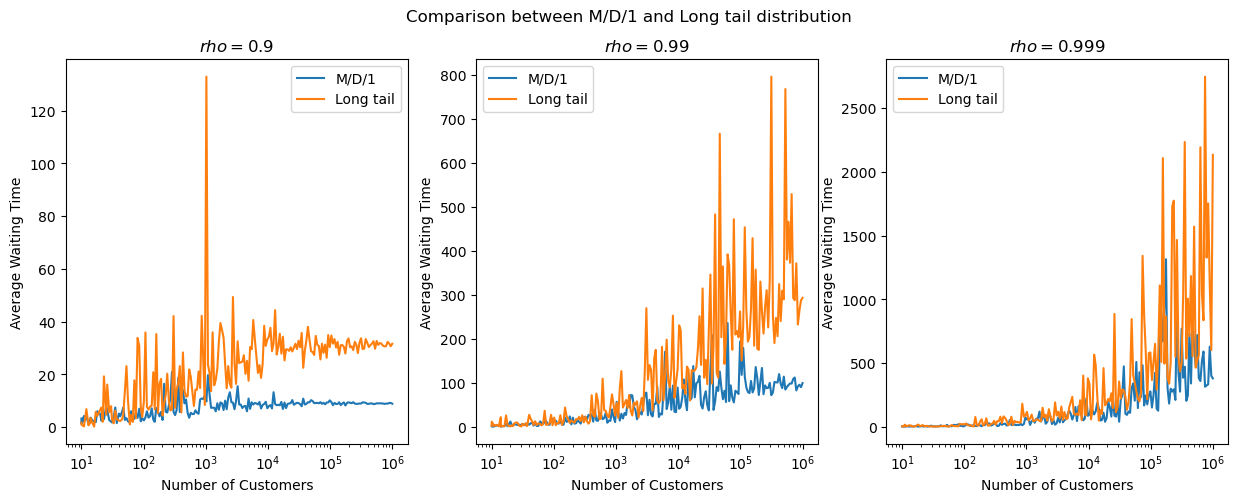

In [15]:
service_time = 2.0
rhos = [0.9, 0.99, 0.999]
num_servers = 1

customer_counts = np.logspace(1, 6, 200, base=10).astype(int)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, rho in enumerate(rhos):
    arrival_interval = service_time / (rho * num_servers)
    average_waits = []
    average_waits_longtail = []
    for count in customer_counts:
        avg_wait = simulate_queue(count, arrival_interval, service_time, num_servers)
        average_waits.append(avg_wait)
        avg_wait_longtail = simulate_queue_longtail(count, arrival_interval, num_servers)
        average_waits_longtail.append(avg_wait_longtail)
        
        
    ax = axes[i]
    ax.plot(customer_counts, average_waits, label='M/D/1')
    ax.plot(customer_counts, average_waits_longtail, label='Long tail')
    ax.set_xscale('log')
    ax.set_xlabel('Number of Customers')
    ax.set_ylabel('Average Waiting Time')
    ax.set_title(f'$rho = {rho}$')
    ax.legend()
    
fig.suptitle('Comparison between M/D/1 and Long tail distribution')
#plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('comparison', dpi=300)